In [1]:
import matplotlib.pylab as plt
plt.rcParams["figure.figsize"] = [16,9]
import seaborn as sns
sns.despine()

from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.normalization import BatchNormalization
from keras.layers import Merge
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger, EarlyStopping
from keras.optimizers import *
from keras.layers.advanced_activations import *
from keras.layers import Convolution1D, MaxPooling1D, AtrousConvolution1D
from keras.layers.recurrent import LSTM, GRU
from keras import regularizers
from sklearn.metrics import roc_curve, auc

import theano
theano.config.compute_test_value = "ignore"

import pandas as pd
import numpy as np


Using TensorFlow backend.


In [2]:
def shuffle_in_unison(a, b):
    # https://stackoverflow.com/questions/4601373/better-way-to-shuffle-two-numpy-arrays-in-unison
    assert len(a) == len(b)
    shuffled_a = np.empty(a.shape, dtype=a.dtype)
    shuffled_b = np.empty(b.shape, dtype=b.dtype)
    permutation = np.random.permutation(len(a))
    for old_index, new_index in enumerate(permutation):
        shuffled_a[new_index] = a[old_index]
        shuffled_b[new_index] = b[old_index]
    return shuffled_a, shuffled_b
 
def create_Xt_Yt(X, y, percentage=0.9):
    p = int(len(X) * percentage)
    X_train = X[0:p]
    Y_train = y[0:p]
     
    X_train, Y_train = shuffle_in_unison(X_train, Y_train)
 
    X_test = X[p:]
    Y_test = y[p:]

    return X_train, X_test, Y_train, Y_test

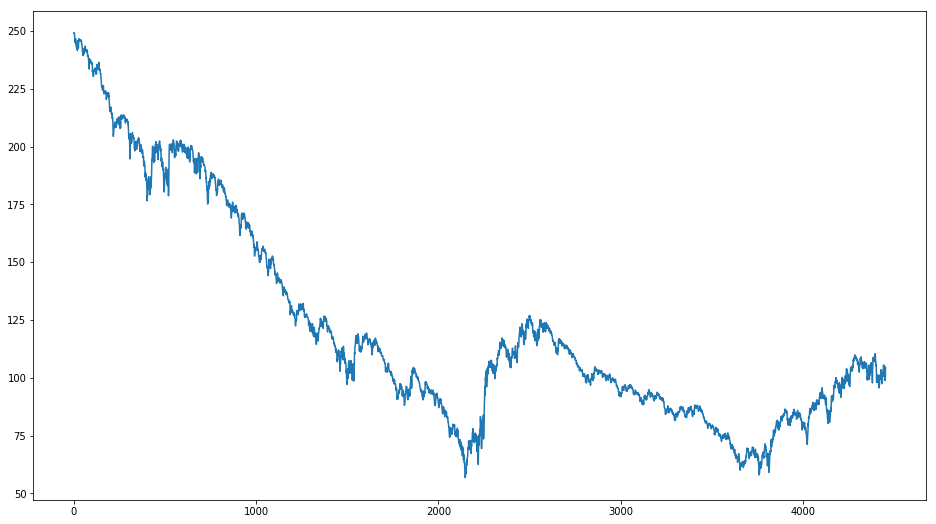

list index out of range


In [3]:
data = pd.read_csv('stockdatas/SPY.csv')[::-1]
data = data.loc[:, 'adjClose'].tolist()

# Uncomment below to use price instead time series
# data = data.loc[:, 'adjClose'].pct_change().dropna().tolist()

plt.plot(data)
plt.show()

WINDOW = 30
EMB_SIZE = 1
STEP = 1
FORECAST = 5

# Straightforward way for creating time windows
X, Y = [], []
for i in range(0, len(data), STEP): 
    try:
        x_i = data[i:i+WINDOW]
        y_i = data[i+WINDOW+FORECAST]  

        last_close = x_i[WINDOW-1]
        next_close = y_i

        if last_close < next_close:
            y_i = [1, 0]
        else:
            y_i = [0, 1] 

    except Exception as e:
        print(e)
        break

    X.append(x_i)
    Y.append(y_i)

X = [(np.array(x) - np.mean(x)) / np.std(x) for x in X] # comment it to remove normalization
X, Y = np.array(X), np.array(Y)

X_train, X_test, Y_train, Y_test = create_Xt_Yt(X, Y)

In [4]:
# https://keras.io/optimizers/
# https://keras.io/activations/

model = Sequential()
model.add(Dense(64, input_dim=30,
                activity_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(LeakyReLU())

model.add(Dropout(0.5))
model.add(Dense(16,
                activity_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(LeakyReLU())
model.add(Dense(2))
model.add(Activation('softmax'))

opt = Adamax(lr=0.001)

reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.9, patience=25, min_lr=0.000001, verbose=1)
checkpointer = ModelCheckpoint(filepath="test.hdf5", verbose=1, save_best_only=True)
model.compile(optimizer=opt, 
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [5]:
history = model.fit(X_train, Y_train, 
          epochs = 100, 
          batch_size = 10, 
          verbose=2, 
          validation_data=(X_test, Y_test),
          callbacks=[reduce_lr, checkpointer],
          shuffle=True)



Train on 3978 samples, validate on 442 samples
Epoch 1/100
Epoch 00000: val_loss improved from inf to 2.07913, saving model to test.hdf5
0s - loss: 3.9499 - acc: 0.4854 - val_loss: 2.0791 - val_acc: 0.4864
Epoch 2/100
Epoch 00001: val_loss improved from 2.07913 to 1.58435, saving model to test.hdf5
0s - loss: 2.2300 - acc: 0.5354 - val_loss: 1.5844 - val_acc: 0.4842
Epoch 3/100
Epoch 00002: val_loss improved from 1.58435 to 1.31758, saving model to test.hdf5
0s - loss: 1.6481 - acc: 0.5576 - val_loss: 1.3176 - val_acc: 0.4910
Epoch 4/100
Epoch 00003: val_loss improved from 1.31758 to 1.15676, saving model to test.hdf5
0s - loss: 1.3271 - acc: 0.5744 - val_loss: 1.1568 - val_acc: 0.4887
Epoch 5/100
Epoch 00004: val_loss improved from 1.15676 to 1.05599, saving model to test.hdf5
0s - loss: 1.1441 - acc: 0.5719 - val_loss: 1.0560 - val_acc: 0.4864
Epoch 6/100
Epoch 00005: val_loss improved from 1.05599 to 0.98946, saving model to test.hdf5
0s - loss: 1.0302 - acc: 0.5721 - val_loss: 0.98

Epoch 00054: val_loss did not improve
0s - loss: 0.6809 - acc: 0.5905 - val_loss: 0.7117 - val_acc: 0.5000
Epoch 56/100
Epoch 00055: val_loss did not improve
0s - loss: 0.6808 - acc: 0.6043 - val_loss: 0.7196 - val_acc: 0.4977
Epoch 57/100
Epoch 00056: val_loss did not improve
0s - loss: 0.6818 - acc: 0.5910 - val_loss: 0.7230 - val_acc: 0.4796
Epoch 58/100
Epoch 00057: val_loss did not improve
0s - loss: 0.6811 - acc: 0.5983 - val_loss: 0.7153 - val_acc: 0.4932
Epoch 59/100
Epoch 00058: val_loss did not improve
0s - loss: 0.6806 - acc: 0.5915 - val_loss: 0.7188 - val_acc: 0.4842
Epoch 60/100
Epoch 00059: val_loss did not improve
0s - loss: 0.6803 - acc: 0.5948 - val_loss: 0.7237 - val_acc: 0.4932
Epoch 61/100
Epoch 00060: val_loss did not improve
1s - loss: 0.6810 - acc: 0.5920 - val_loss: 0.7253 - val_acc: 0.4932
Epoch 62/100
Epoch 00061: val_loss did not improve
0s - loss: 0.6804 - acc: 0.5890 - val_loss: 0.7240 - val_acc: 0.4796
Epoch 63/100
Epoch 00062: val_loss did not improve
0s

In [6]:
scores = model.evaluate(X_test, Y_test, verbose=1)
print("\nModel Accuracy: %.2f%%" % (scores[1]*100))

 32/442 [=>............................] - ETA: 0s
Model Accuracy: 50.23%


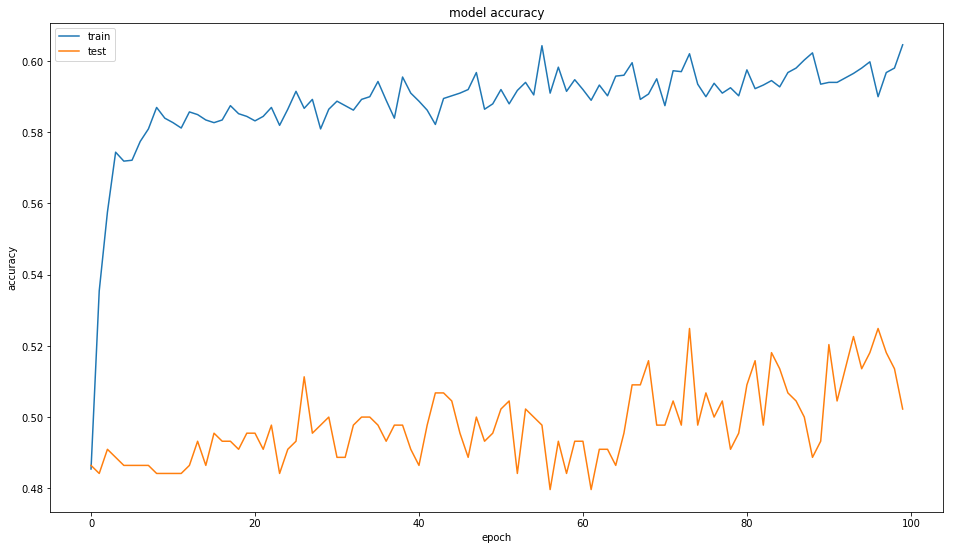

In [7]:
plt.figure()
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

Predicting on test data
Generating results


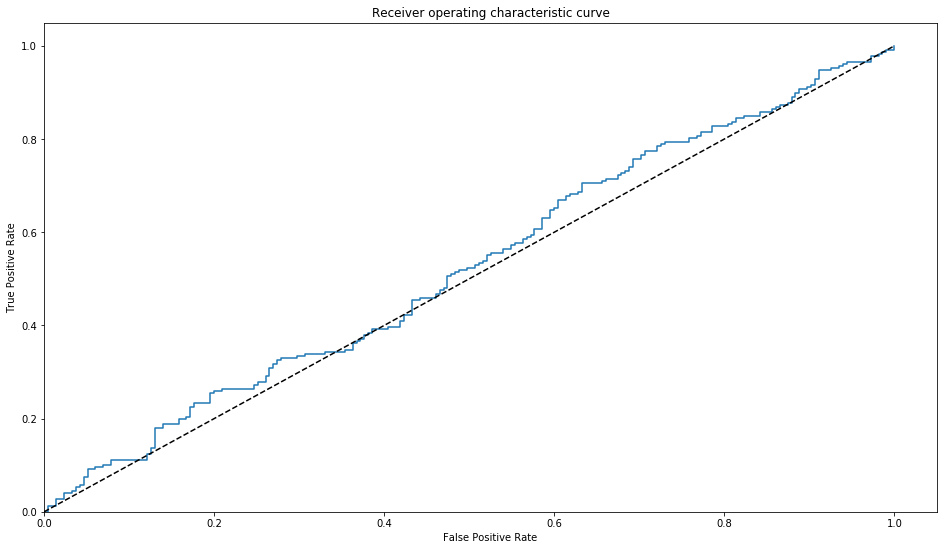

AUC: 0.525172


In [8]:
def generate_results(y_test, y_score):
    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.05])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic curve')
    plt.show()
    print('AUC: %f' % roc_auc)
    
print('Predicting on test data')
y_score = model.predict(X_test)

print('Generating results')
generate_results(Y_test[:, 0], y_score[:, 0])